# Introduction
Down syndrome (DS) is a chromosomal abnormality (trisomy of human chromosome 21) associated with intellectual disability and affecting approximately one in 1000 live births worldwide. The overexpression of genes encoded by the extra copy of a normal chromosome in DS is believed to be enough to perturb normal pathways and normal responses to stimulation, causing learning and memory deficits.
The data presented in Data_Cortex_Nuclear.csv are expression levels of 77 proteins measures in the cerebral cortex of mice exposed to context fear conditioning, a task used to assess associative learning. We will analyze expression level of proteins obtained from normal genotype control mice and from their trisomic littermates (Ts65Dn) both with and without treatment with the drug Memantine. Control mice can learn successfully while the trisomic mice fail, unless they are first treated with the drug, which rescues their learning ability. The dataset contains a total of 1080 measurements per protein, each measurement is considered an independent sample/mouse.


# Motivation
Identify reduced subsets of proteins that can best discriminate between normal learning, failed learning and rescued learning in mice. We will also provide a visual representation of the data that will allow us to extract patterns that may demonstrate novel biological significance of the different kinds of learning and the response to memantine.

Classes of mice, associated treatments and learning outcomes are presented in the following figure:

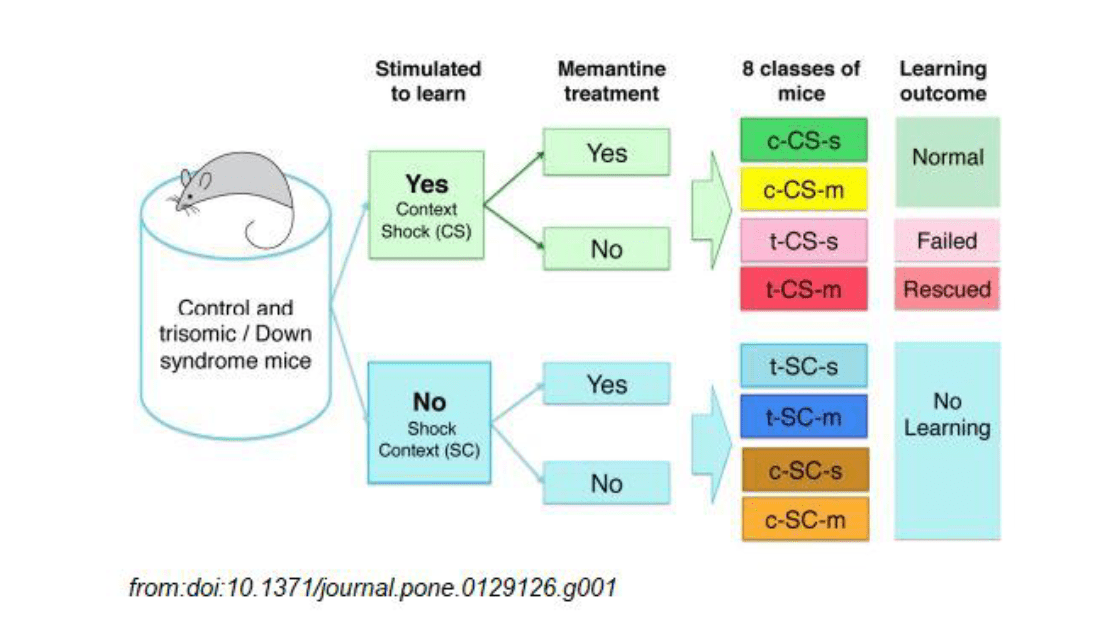

In [1]:
# Import libraries

import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

### 1. preprocess_data(filename)
* receives the path to the data file (str), reads the csv into a dataframe, and performs the following preprocessing:
* Use MouseID as the index column for the dataframe.
* Some proteins have missing data, and we would like to analyze only complete data. i remove from the data the proteins that have more than 10 missing values. After removing the proteins, i remove the mice that have any missing protein values.
* Add a column called “Learning” that matches the learning outcome for each class of mice according to the figure above. The possible learning outcomes are – ‘Normal’, ‘Failed’, ‘Rescued’, ‘No Learning’.

In [2]:
def preprocess_data(filename):
    df = pd.read_csv(filename, index_col='MouseID')
    ## remove columns with more than 10 na values
    N = 10
    df = df.dropna(thresh=len(df) - N, axis=1)
    # drop all the row with null value
    df = df.dropna(how='any', axis=0)
    ## check if the are stell null value
    #print(df.isnull().sum().sum())

    dict_Learning = {'c-CS-m': 'Normal', 'c-SC-m': 'No Learning', 'c-CS-s': 'Normal', 'c-SC-s': 'No Learning',
                     't-CS-m': 'Rescued', 't-SC-m': 'No Learning', 't-CS-s': 'Failed', 't-SC-s': 'No Learning'}
    learning = []
    for row in df['class']:
        for key in dict_Learning:
            if row == key:
                learning.append(dict_Learning[key])
    df['learning'] = learning
    return df



### More background information
We would like to find the proteins that allow us to discriminate between the different classes of mice. For
example, we would like to identify which of the changes seen in control mice are required for successful
learning, which of the abnormalities in the Ts65Dn directly contributes to failed learning, and which changes
induced by memantine are critical for rescuing successful learning in the Ts65Dn.
Given the eight classes of mice, there are 28 possible pairwise comparisons, but only a subset of these are
biologically meaningful. Table 1 lists the meaningful comparisons and their biological relevance (CFC =
Context Fear Conditioning).

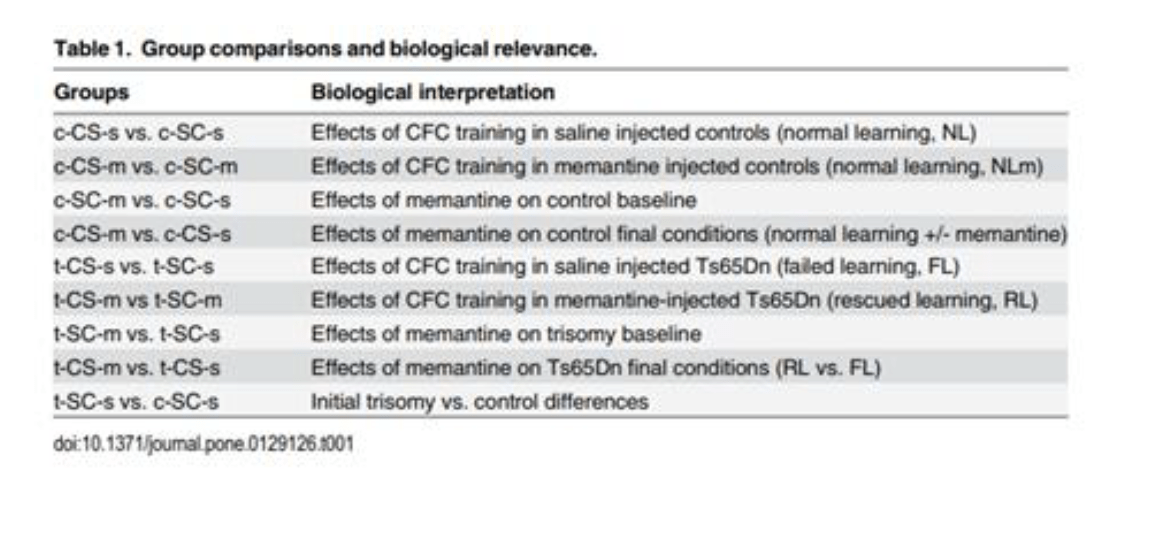

### Statistical test
To quantitively identify proteins whose expression levels are significantly different between classes we use the
Mann-Whitney U test, often used in gene expression analysis. Mann-Whitney tests whether distributions of the
two variables are the same. The null hypothesis of the test is that they are equal, so a small p-value means we
can reject the null hypothesis → the distributions are not equal.

### 2. get_discriminant_proteins(df, class1, class2, thresh, outcome=False)
* Receives as input: the protein dataframe, two class names (e.g. “t-CS-m”, ”t-CS-s”), and a threshold (float) 0<thresh<1. If outcome=True, then instead of classes, the function receives learning outcomes (e.g. “Normal”, “Failed”).
* For each protein, i use the Mann-Whitney U Test to compare the protein expressions for mice that belong to class1 versus mice that belong to class2.
* The result order by a dictionary sorted ascending by p-value called p_values_dict whose keys are the protein names and the values are the resulting p-values from Mann-Whitney U test.

In [3]:
def get_discriminant_proteins(df, class1, class2, thresh, outcome):
    p_values_dict = {}
    if outcome is True:
        cls1 = df[df['class'] == class1]['learning'].values[0]
        df_cls1 = df[df['learning'] == cls1].drop(['class', 'learning'], axis=1)
        cls2 = df[df['class'] == class2]['learning'].values[0]
        df_cls2 = df[df['learning'] == cls2].drop(['class', 'learning'], axis=1)
        for class1 in df_cls1:
            for class2 in df_cls2:
                if class1 == class2:
                    res = scipy.stats.mannwhitneyu(df_cls1[class1], df_cls2[class2])
                    p_values_dict[class1] = res[1]

    elif outcome is False:
        df_cls1 = df[df['class'] == class1].drop(['class', 'learning'], axis=1)
        df_cls2 = df[df['class'] == class2].drop(['class', 'learning'], axis=1)
        for class1 in df_cls1:
            for class2 in df_cls2:
                if class1 == class2:
                    res = scipy.stats.mannwhitneyu(df_cls1[class1], df_cls2[class2])
                    p_values_dict[class1] = res[1]

    sorted_kv = sorted(p_values_dict.items(), key=lambda kv: kv[1])
    sorted_proteins = [kv[0] for kv in sorted_kv if kv[1] < thresh]

    return sorted_proteins, p_values_dict

### 3. count_discriminant_proteins(df) 
* Returns a new dataframe which contains for each of the class pairings in Table 1, the proportion of proteins that discriminate the classes with p-value<0.05.

In [4]:
def count_discriminant_proteins(df):
    class1 = ['c-CS-s', 'c-CS-m', 'c-SC-m', 'c-CS-m', 't-CS-s',
              't-CS-m', 't-SC-m', 't-CS-m', 't-SC-s']

    class2 = ['c-SC-s', 'c-SC-m', 'c-SC-s', 'c-CS-s', 't-SC-s',
              't-SC-m', 't-SC-s', 't-CS-s', 'c-SC-s']

    list_class = []
    for key1, key2 in zip(class1, class2):
        list_class.append(key1 + ',' + key2)

    set_option = set()
    for key1 in class1:
        for key2 in class2:
            set_option.add(key1 + ',' + key2)

    data = []
    for key in set_option:
        if key in list_class:
            key = key.split(',')
            class1 = key[0]
            class2 = key[1]
            discriminant_proteins, dig_p_value = get_discriminant_proteins(df, class1, class2, thresh=0.05,
                                                                           outcome=False)
            data.append([class1, class2, str(len(discriminant_proteins) / len(dig_p_value))])

    df_new = pd.DataFrame(data, columns=['class1', 'class2', 'disc_proteins'])
    return df_new



### 4. plotting_data(df)
* explore which changes induced by memantine are critical for rescuing successful learning in the Ts65Dn.
* Find the 8 proteins that best discriminate the learning outcomes Failed and Rescued (smallest pvalues)
* For these 8 proteins, plot the distributions of protein expression for the mice that belong to each of the learning outcomes Failed and Rescued, separately.
* This visualization gives us an idea of what a protein that discriminates between classes looks like versus one that doesn’t discriminate.

In [5]:
def plotting_data(df):
    class1 = df[df['learning'] == 'Failed']['class'].values[0]
    class2 = df[df['learning'] == 'Rescued']['class'].values[0]
    discriminant_proteins, dig_p_value = get_discriminant_proteins(df, class1, class2, thresh=0.05, outcome=True)
    discr = discriminant_proteins[:8]
    discr.append('class')
    discr.append('learning')
    df_new = df[discr]
    df_new = df_new[(df.learning == 'Failed') | (df.learning == 'Rescued')]
    colums = df_new.columns
    list_tupel = []
    for i in range(2):
        for j in range(4):
            result = [i, j]
            list_tupel.append(tuple(result))
    fig, axes = plt.subplots(2, 4, figsize=(15, 15))
    fig.suptitle('Rescued vs Failed')
    for i, j in zip(range(8), list_tupel):
        param = colums[i]
        sns.histplot(data=df_new, x=df_new[param], ax=axes[j[0], j[1]], kde=True, element="step", hue='learning')
        axes[j[0], j[1]].set_xlabel(colums[i], fontsize=10)
        axes[j[0], j[1]].tick_params(labelsize=12)  # set tick labels size
    plt.show()



### 5. build_mice_outcome_predictor(df)
I would like to build a machine learning model that when given the protein expression for a mouse can predict the Learning Outcome for this mouse. To do this, i will use the supervised learning algorithm K-Nearest Neighbors (KNN):
* Split the protein data (with train_test_split), leaving 10% of the data as test set.
* Fit a KNN model with 3 neighbors to the training data.
* Predict learning outcomes for the test data.
* Print the accuracy score of the prediction.
* Return the model object.

In [6]:
def build_mice_outcome_predictor(df):
    global y_pred, knn
    df_unlabeled = df.drop(['learning', 'class'], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(df_unlabeled, df['learning'], test_size=0.1, random_state=0)
    # print(X_train.shape, y_train.shape)
    # print(X_test.shape, y_test.shape)

    X = df_unlabeled
    Y = df['learning']
    kf = KFold(n_splits=3, shuffle=True)
    kf.get_n_splits(X)
    # print(kf)
    # KFold(n_splits=5, random_state=None, shuffle=True)
    for train_index, test_index in kf.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = Y[train_index], Y[test_index]

    # with cross-validation

    kf = KFold(n_splits=3, shuffle=True)
    kf.get_n_splits(X)
    k_range = list(range(1, 26))
    scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        scores.append(metrics.accuracy_score(y_test, y_pred))

    plt.plot(k_range, scores, 'o--')
    plt.xlabel('Value of k for KNN')
    plt.ylabel('Accuracy Score')
    plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
    plt.show()

    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    print('accuracy_score:', accuracy_score)
    Classifier = KNeighborsClassifier.get_params(knn)
    print('KNeighborsClassifier', Classifier)
    # confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    # print('confusion_matrix',confusion_matrix)
    return knn


### 6. get_mouse_learning_outcome(knn,samples)
* receives as input the model from the previous function you created, and an array of one (or more) mice samples. The function predicts the learning outcome for each of the mice with the model (knn) and returns a list of the outcomes.

In [7]:
def get_mouse_learning_outcome(knn, samples):
    result = knn.predict(samples)
    return result

### Helper function generate_mice(df, n)
* generate 10 mice samples, and with your function, predict their learning outcomes.

In [8]:
def generate_mice(df, n):
    desc = df.describe()
    mice = np.empty(shape=(0, desc.shape[1]))
    for i in range(n):
        mouse = np.random.normal(loc=desc.loc['mean', :], scale=desc.loc['std', :])
        mice = np.insert(mice, 0, mouse, axis=0)
    return mice

### Execute the code

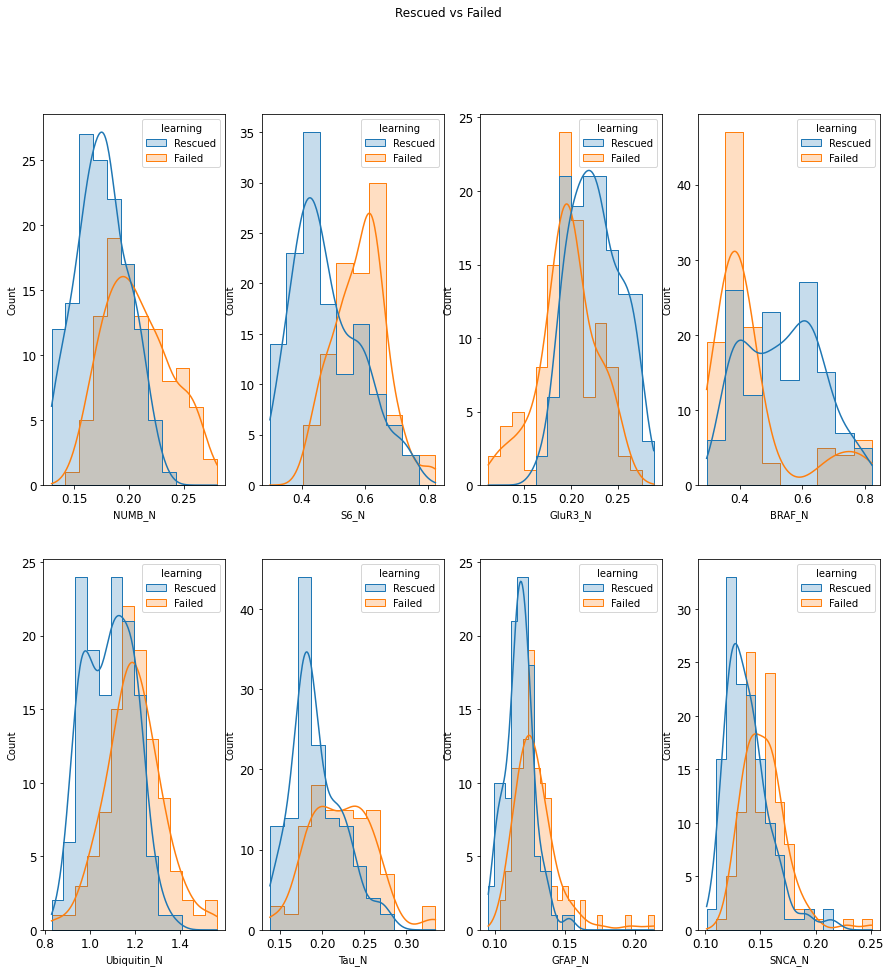

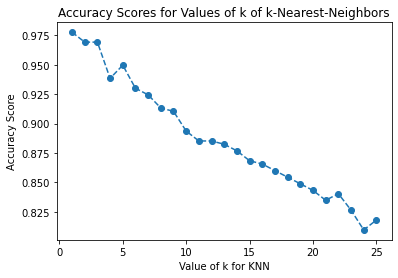

accuracy_score: 0.8179271708683473
KNeighborsClassifier {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 25, 'p': 2, 'weights': 'uniform'}
['No Learning' 'No Learning' 'No Learning' 'Failed' 'No Learning'
 'No Learning' 'No Learning' 'No Learning' 'No Learning' 'Normal']


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


In [9]:
df = preprocess_data(r'/kaggle/input/cortex-nuclear/Data_Cortex_Nuclear.csv')
count_discriminant = count_discriminant_proteins(df)
plotting_data(df)
knn = build_mice_outcome_predictor(df)
mouse_learning_outcome = get_mouse_learning_outcome(knn, generate_mice(df, 10))
print(mouse_learning_outcome)
